+------------------+------------------+---------------------+-----------------+
|sentiment_combined|avg(word_count)   |avg(lexical_richness)|avg(unique_words)|
+------------------+------------------+---------------------+-----------------+
|positive          |45.537772176713574|0.8919018465506481   |32.80326261989778|
|negative          |50.523741350513006|0.8747241396575133   |36.521116678597  |
+------------------+------------------+---------------------+-----------------+



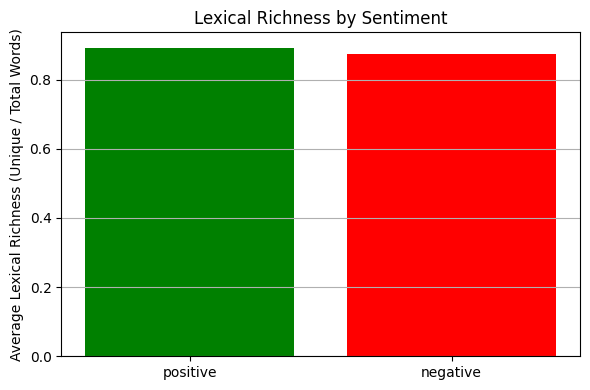

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, length, split, size, expr

# 1. Start SparkSession
spark = SparkSession.builder.appName("Hypothesis3").getOrCreate()

# 2. Load the dataset
df = spark.read.option("header", True).csv("clean_sample.csv")

# 3. Filter for valid sentiment labels (optional, safety check)
df = df.filter((col("sentiment_combined") == "positive") | (col("sentiment_combined") == "negative"))

# 4. Add word-level features
df = df.withColumn("word_list", split(col("review_text"), " "))  # list of words
df = df.withColumn("word_count", size(col("word_list")))         # total number of words
df = df.withColumn("unique_words", expr("size(array_distinct(word_list))"))  # unique words
df = df.withColumn("lexical_richness", col("unique_words") / col("word_count"))  # type-token ratio

# 5. Group by sentiment and compute averages
agg_df = df.groupBy("sentiment_combined").agg(
    {"word_count": "avg", "unique_words": "avg", "lexical_richness": "avg"}
)

# 6. Show results
agg_df.show(truncate=False)

# Convert to Pandas for easy plotting
agg_pd = agg_df.toPandas()

# Rename for readability
agg_pd.columns = ['Sentiment', 'Avg_Word_Count', 'Avg_Lexical_Richness', 'Avg_Unique_Words']

# Plot lexical richness
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(agg_pd['Sentiment'], agg_pd['Avg_Lexical_Richness'], color=['green', 'red'])
plt.title("Lexical Richness by Sentiment")
plt.ylabel("Average Lexical Richness (Unique / Total Words)")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

